Same approach as tfidf_baseline_readmes.ipynb but using repo descriptions rather than README's to classify.

In [1]:
import pandas as pd
import os
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import markdown # pip install markdown
from bs4 import BeautifulSoup # pip install beautifulsoup4

ModuleNotFoundError: No module named 'google.colab'

In [16]:
data_path = "../feature_extraction"
naics = pd.read_csv(data_path+"/NAICS descriptions.csv")
map = zip(naics["Sector"], naics["Definition"])
# naics = naics.drop("Definition", axis=1)
naics = naics.drop([18])
naics

,Sector,Definition,Descriptions
0,11,"Agriculture, Forestry, Fishing and Hunting","The Agriculture, Forestry, Fishing and Hunting..."
1,21,"Mining, Quarrying, and Oil and Gas Extraction","The Mining, Quarrying, and Oil and Gas Extract..."
2,22,Utilities,The Utilities sector comprises establishments ...
3,23,Construction,The Construction sector comprises establishmen...
4,31-33,Manufacturing,The Manufacturing sector comprises establishme...
5,42,Wholesale Trade,The Wholesale Trade sector comprises establish...
6,44-45,Retail Trade,The Retail Trade sector comprises establishmen...
7,48-49,Transportation and Warehousing,The Transportation and Warehousing sector incl...
8,51,Information,The Information sector comprises establishment...
9,52,Finance and Insurance,The Finance and Insurance sector comprises est...


In [6]:
def md_to_text(md):
    html = markdown.markdown(md)
    soup = BeautifulSoup(html, features='html.parser')
    return soup.get_text()

import re
import numpy as np
def clean_readme(text):
    if isinstance(text, str):
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove Markdown image tags (![...](...))
        text = re.sub(r'!\[.*?\]\(.*?\)', '', text)

        # Remove Markdown links ([...](...))
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)

        if len(text) < 5:
          return np.nan

        return text
    else:
        # Handle cases where the input is not a string (e.g., None)
        return ""

In [33]:
# data_path = "/content/drive/MyDrive/[Fall 23] DC-Github/Models/"
# os.chdir(data_path)
corpus = pd.read_csv(data_path+"/Testing_corpus_descriptions.csv")
corpus["Description"] = corpus["Description"].apply(md_to_text).str.replace('\n', '')
corpus['Length'] = [len(x.split()) for x in corpus['Description'].tolist()]
corpus



,Sector,Description,Length
0,11,Classification of crop disease (yellow rust) f...,12
1,11,tutorials made for biologists to learn deep le...,8
2,11,A voting classifier based machine learning sys...,28
3,11,Online texture triangle visualizer.,4
4,11,This website provides research support for stu...,16
...,...,...,...
89,72,Food or Item Order Management System,6
90,92,The organized list of awesome @italia projects,7
91,92,Report.it è un applicativo Android/iOS svilupp...,13
92,92,🌐 🧑‍🏫 Website for graduate-level course on com...,15


In [34]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# TF-IDF vectorization for the NAICS descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(naics['Descriptions'])

In [35]:
# Function to find the closest NAICS topic using cosine distance
def find_closest_topic_cosine(descr_text):
    # TF-IDF vectorization for the GitHub README
    descr_tfidf = tfidf_vectorizer.transform([descr_text])
    # print(descr_tfidf.shape)

    # Calculate cosine similarity between the README and each NAICS topic
    similarities = cosine_similarity(descr_tfidf, tfidf_matrix)

    # Find the topic with the highest similarity
    # print(similarities)
    closest_topic_index = similarities.argmax()
    closest_topic = naics['Sector'].iloc[closest_topic_index]
    # closest_topic_label = naics[naics["Sector"] == closest_topic]["Definition"]

    return closest_topic



In [36]:
# Function to find the closest NAICS topic using euclidean distance
def find_closest_topic_euclidean(descr_text):
    # TF-IDF vectorization for the GitHub README
    descr_tfidf = tfidf_vectorizer.transform([descr_text])

    # Calculate cosine similarity between the README and each NAICS topic
    similarities = cosine_similarity(descr_tfidf, tfidf_matrix)

    # Find the topic with the highest similarity
    # print(similarities)
    closest_topic_index = similarities.argmax()
    closest_topic = naics['Sector'].iloc[closest_topic_index]
    # closest_topic_label = naics[naics["Sector"] == closest_topic]["Definition"]

    return closest_topic

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
corpus['TFIDF Cosine'] = corpus['Description'].apply(find_closest_topic_cosine)
# Calculate accuracy
accuracy = accuracy_score(corpus['Sector'], corpus['TFIDF Cosine'])
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(corpus['Sector'], corpus['TFIDF Cosine'], average="macro")
print("Precision:", precision)


# Calculate recall
recall = recall_score(corpus['Sector'], corpus['TFIDF Cosine'], average="macro")
print("Recall:", recall)



Accuracy: 0.3723404255319149
Precision: 0.3257518796992481
Recall: 0.3710526315789474


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
corpus['TFIDF Euclidean'] = corpus['Description'].apply(find_closest_topic_euclidean)
# Calculate accuracy
accuracy = accuracy_score(corpus['Sector'], corpus['TFIDF Euclidean'])
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(corpus['Sector'], corpus['TFIDF Euclidean'], average="macro")
print("Precision:", precision)


# Calculate recall
recall = recall_score(corpus['Sector'], corpus['TFIDF Euclidean'], average="macro")
print("Recall:", recall)

Accuracy: 0.3723404255319149
Precision: 0.3257518796992481
Recall: 0.3710526315789474


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
misclassified = corpus[corpus["Sector"]!=corpus["TFIDF Cosine"]]
misclassified["Length"].value_counts(bins = [0,10, 50, 100, 1000])

(10.0, 50.0]       31
(-0.001, 10.0]     26
(50.0, 100.0]       2
(100.0, 1000.0]     0
Name: Length, dtype: int64

In [40]:
correct = corpus[corpus["Sector"]==corpus["TFIDF Cosine"]]
correct["Length"].value_counts(bins = [0,10, 50, 100, 1000])

(10.0, 50.0]       21
(-0.001, 10.0]     13
(50.0, 100.0]       1
(100.0, 1000.0]     0
Name: Length, dtype: int64

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

Text(0.5, 23.52222222222222, 'Predicted')

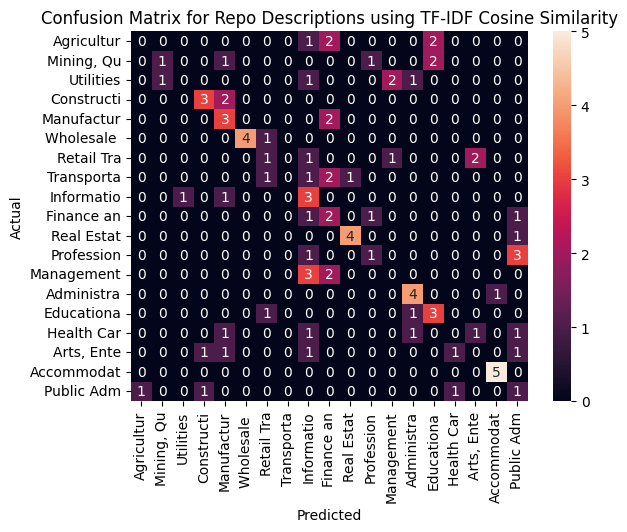

In [42]:
test_class = naics['Sector']
test_true = corpus['Sector']
test_pred = corpus['TFIDF Cosine']
truncated = [i[0:10] for i in naics['Definition']]
plt.figure()
cf= confusion_matrix(test_true, test_pred, labels=naics['Sector'])
cm_df = pd.DataFrame(cf, index=truncated, columns=truncated)
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for Repo Descriptions using TF-IDF Cosine Similarity')
plt.ylabel('Actual')
plt.xlabel('Predicted')